# Amplitude Signal Modulation

This notebook demonstrates various analog modulation techniques:
1. **Amplitude Modulation (AM / DSB-FC)**
2. **Double Sideband Suppressed Carrier (DSB-SC)**
3. **Single Sideband (SSB)**
4. **Vestigial Sideband (VSB)**

Each section includes the mathematical theory, Python implementation, and visualization in both time and frequency domains.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# Global Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

# Simulation Parameters
fs = 100_000        # sampling frequency (Hz)
fc = 10_000         # carrier frequency (Hz)
fm = 500            # message frequency (Hz)
duration = 0.02     # seconds (increased slightly for better visual)

t = np.arange(0, duration, 1/fs)

# Common Signals
# Message Signal (Single Tone)
Am = 1.0
m_t = Am * np.sin(2 * np.pi * fm * t)

# Carrier Signal (Cosine for standard derivation)
Ac = 1.0
c_t = Ac * np.cos(2 * np.pi * fc * t)

print(f"Sampling Frequency: {fs} Hz")
print(f"Carrier Frequency: {fc} Hz")
print(f"Message Frequency: {fm} Hz")

Sampling Frequency: 100000 Hz
Carrier Frequency: 10000 Hz
Message Frequency: 500 Hz


### Helper Functions

In [2]:
def plot_spectrum(sig, fs, title="Frequency Spectrum"):
    """
    Helper function to plot the magnitude spectrum of a signal.
    """
    n = len(sig)
    k = np.arange(n)
    T = n/fs
    frq = k/T 
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(sig)/n # fft computing and normalization
    Y = Y[range(n//2)]
    
    plt.figure()
    plt.plot(frq, abs(Y), 'b') 
    plt.xlabel('Freq (Hz)')
    plt.ylabel('|Y(freq)|')
    plt.title(title)
    plt.xlim(0, fc + 5*fm) # Zoom in around carrier
    plt.grid(True)
    plt.show()

def plot_time_domain(t, sig, title, envelope=None):
    plt.figure()
    plt.plot(t, sig, label='Modulated Signal')
    if envelope is not None:
         plt.plot(t, envelope, 'r--', label='Envelope')
         plt.plot(t, -envelope, 'r--', label='Envelope')
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

## 1. Amplitude Modulation (DSB-FC)

In Amplitude Modulation (Double Sideband Full Carrier), the amplitude of the carrier is varied in proportion to the message signal.

**Equation:**
$$ s_{AM}(t) = [1 + k_a m(t)] A_c \cos(2\pi f_c t) $$

where:
- $k_a$ is the amplitude sensitivity.
- $|k_a m(t)| \le 1$ to avoid overmodulation.



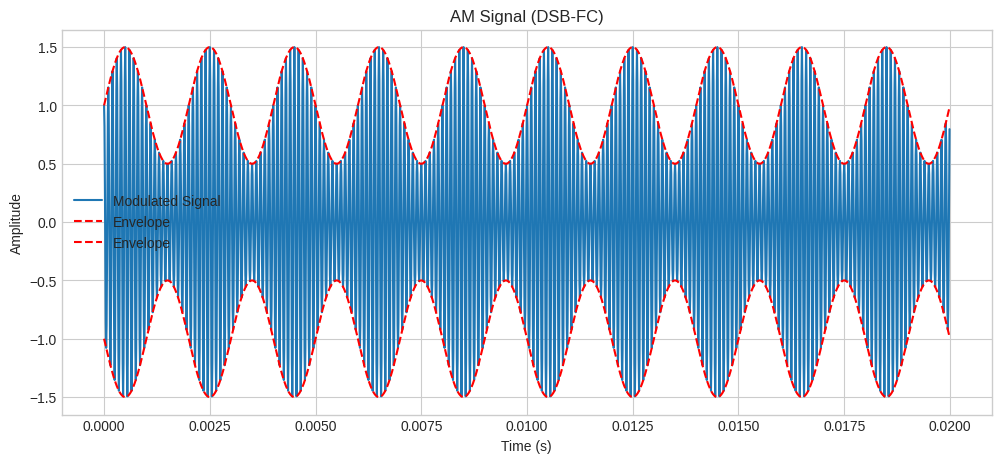

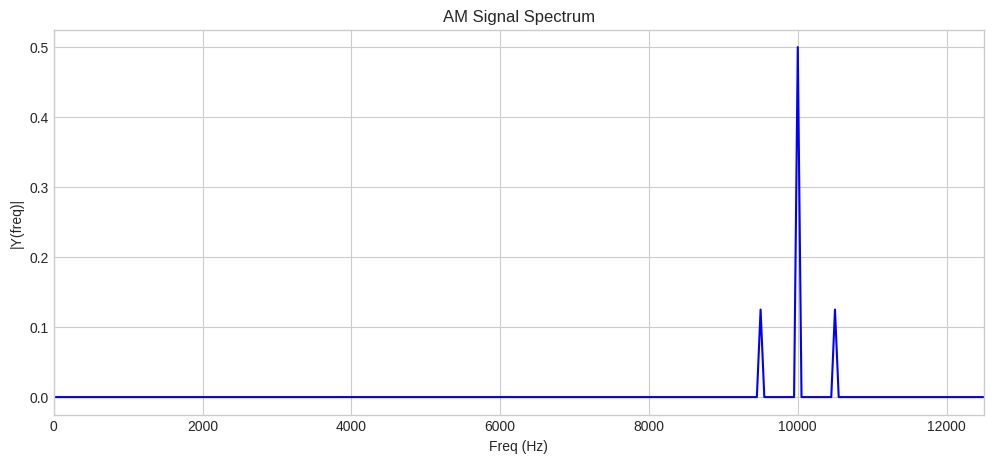

In [3]:
ka = 0.5  # Modulation index (0.5 for 50% modulation)

# AM Signal
s_am = (1 + ka * m_t) * c_t

# Envelope for plotting
envelope = Ac * (1 + ka * m_t)

plot_time_domain(t, s_am, "AM Signal (DSB-FC)", envelope=envelope)
plot_spectrum(s_am, fs, "AM Signal Spectrum")

## 2. Double Sideband Suppressed Carrier (DSB-SC)

DSB-SC modulation transmits the sidebands but suppresses the carrier component, improving power efficiency.

**Equation:**
$$ s_{DSB-SC}(t) = m(t) \cos(2\pi f_c t) $$

Note the phase reversal when the message signal crosses zero.

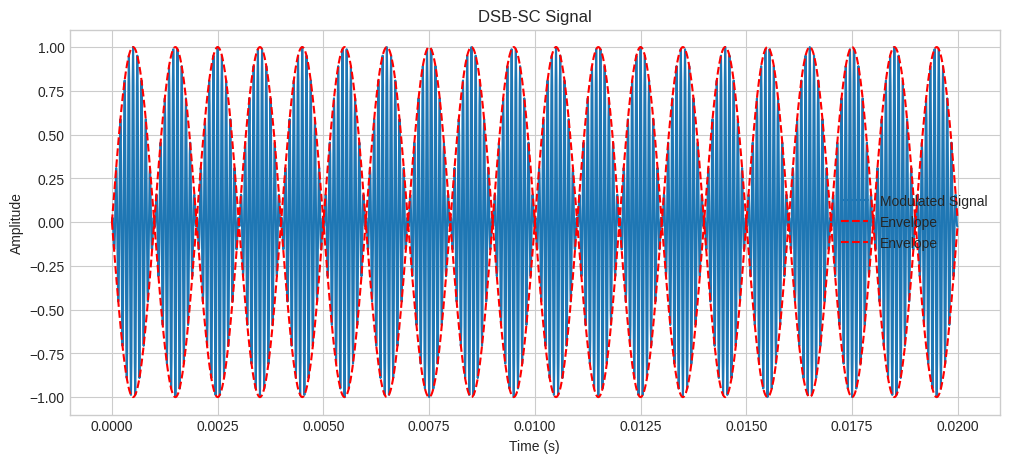

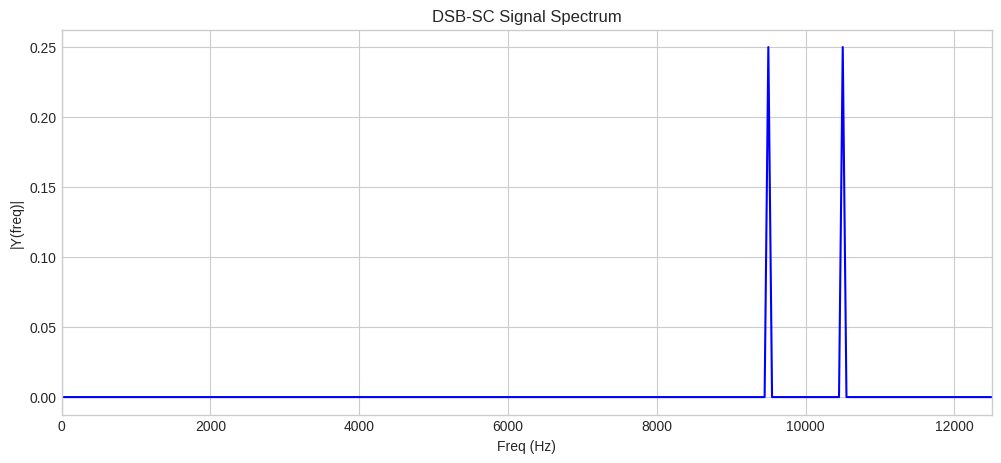

In [4]:
# DSB-SC Signal
s_dsb_sc = m_t * c_t

plot_time_domain(t, s_dsb_sc, "DSB-SC Signal", envelope=np.abs(m_t))
plot_spectrum(s_dsb_sc, fs, "DSB-SC Signal Spectrum")

## 3. Single Sideband (SSB)

SSB modulation transmits only one of the sidebands (Upper or Lower), reducing bandwidth requirements by half compared to DSB.

**Equation:**
$$ s_{SSB}(t) = m(t)\cos(2\pi f_c t) \mp \hat{m}(t)\sin(2\pi f_c t) $$

- Minus sign ($-$) corresponds to **Upper Sideband (USB)**.
- Plus sign ($+$) corresponds to **Lower Sideband (LSB)**.

where $\hat{m}(t)$ is the Hilbert transform of $m(t)$ (a -90 degree phase shift).

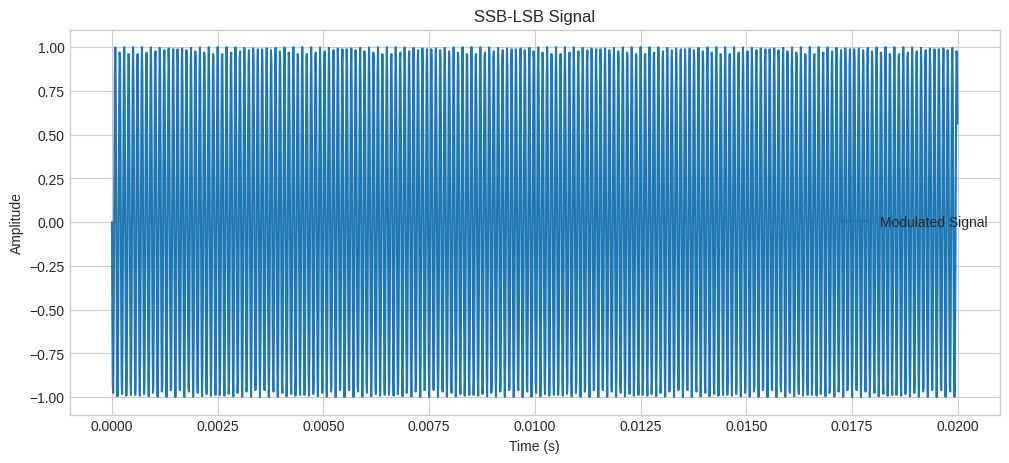

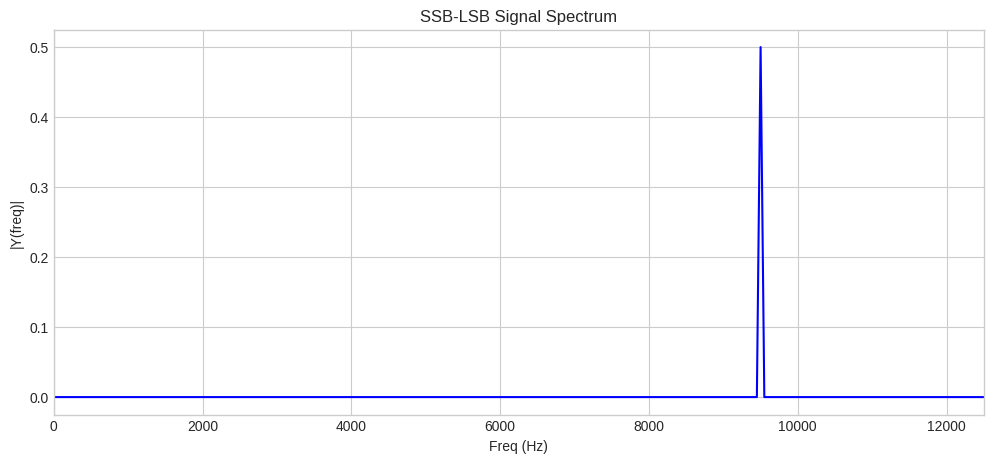

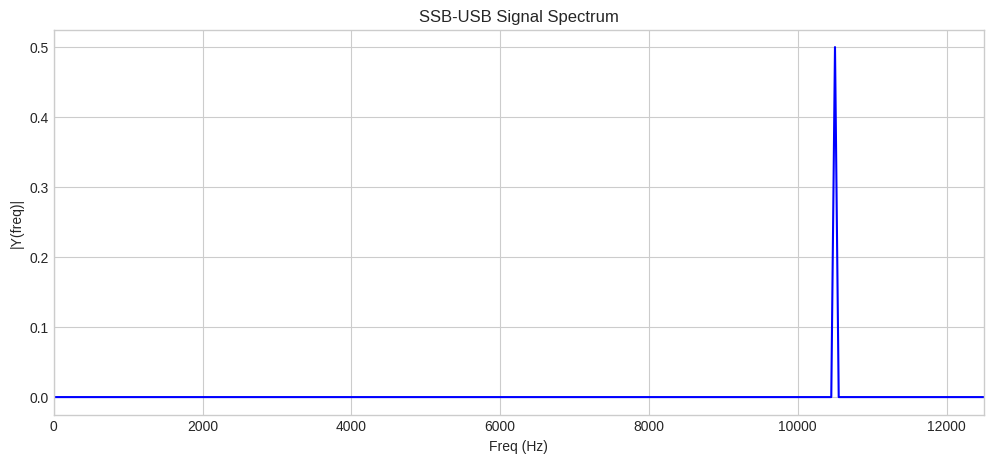

In [5]:
# Hilbert Transform of message
m_hat = np.imag(hilbert(m_t))

# Carrier Quadrature component: Ac * sin(2*pi*fc*t)
# Note: cos(x - pi/2) = sin(x), so this is a 90 deg shift of carrier
c_t_quad = Ac * np.sin(2 * np.pi * fc * t)

# SSB - Lower Sideband (LSB) => Plus sign
s_ssb_lsb = m_t * c_t + m_hat * c_t_quad

# SSB - Upper Sideband (USB) => Minus sign
s_ssb_usb = m_t * c_t - m_hat * c_t_quad

# Plotting LSB
plot_time_domain(t, s_ssb_lsb, "SSB-LSB Signal")
plot_spectrum(s_ssb_lsb, fs, "SSB-LSB Signal Spectrum")

# Plotting USB
plot_spectrum(s_ssb_usb, fs, "SSB-USB Signal Spectrum")

## 4. Vestigial Sideband (VSB)

VSB is a compromise between DSB and SSB. One sideband is passed almost completely, while only a "vestige" (trace) of the other sideband is retained. This allows for easier filtering than SSB.

This simulation uses a band-limited noise signal as the message to better demonstrate the spectral shaping.

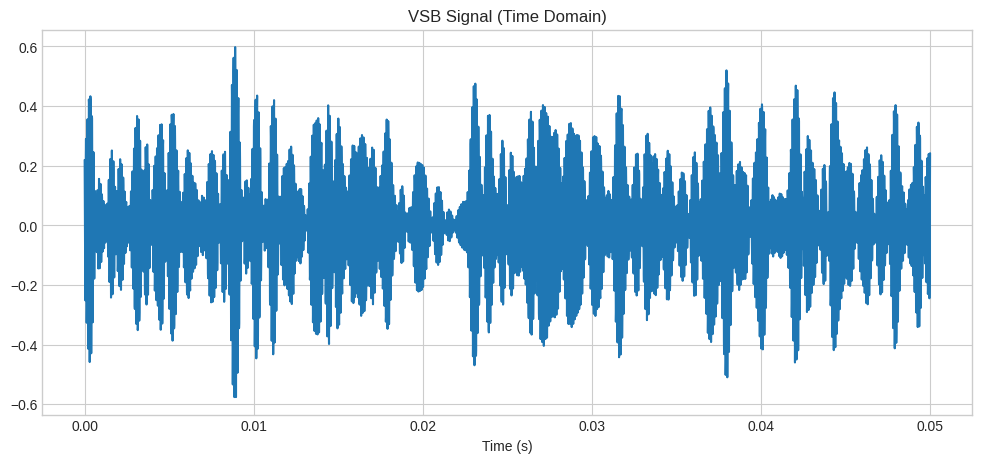

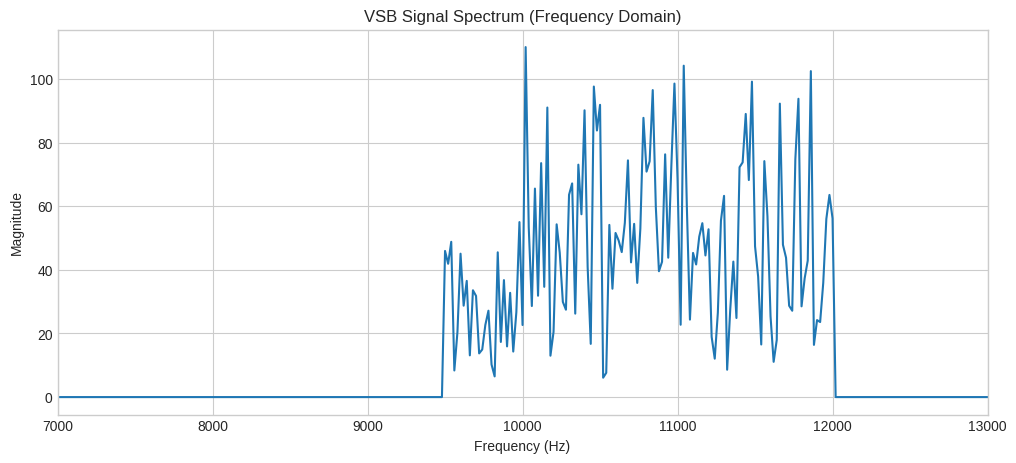

In [6]:
# VSB Simulation using Frequency Domain Filtering

# Parameters for VSB
Bm = 2_000            # Message bandwidth (Hz)
vestige_bw = 500      # Vestigial bandwidth (Hz)

# Create a band-limited message signal (Noise)
np.random.seed(42)
T_vsb = 0.05
t_vsb = np.arange(0, T_vsb, 1/fs)
noise = np.random.randn(len(t_vsb))

# Filter noise to create band-limited message
freqs = np.fft.fftfreq(len(noise), 1/fs)
M_spec = np.fft.fft(noise)
M_spec[np.abs(freqs) > Bm] = 0
m_vsb = np.real(np.fft.ifft(M_spec))
m_vsb /= np.max(np.abs(m_vsb)) # Normalize

# Generate DSB-SC first
c_vsb = np.cos(2 * np.pi * fc * t_vsb)
s_dsb_vsb = m_vsb * c_vsb

# Apply VSB Filter in Frequency Domain
S_spec = np.fft.fft(s_dsb_vsb)
H = np.zeros_like(freqs)

# Define Filter H(f)
# Pass Upper Sideband fully: (fc, fc+Bm)
H[(freqs >= fc) & (freqs <= fc + Bm)] = 1.0
H[(freqs <= -fc) & (freqs >= -fc - Bm)] = 1.0 # Negative freqs

# Pass Vestige of Lower Sideband: (fc-vestige, fc)
H[(freqs >= fc - vestige_bw) & (freqs < fc)] = 0.5
H[(freqs <= -fc + vestige_bw) & (freqs > -fc)] = 0.5 # Negative freqs

# Apply Filter
S_vsb_spec = S_spec * H
s_vsb_out = np.real(np.fft.ifft(S_vsb_spec))

# Plot Time Domain
plt.figure(figsize=(12, 5))
plt.plot(t_vsb, s_vsb_out)
plt.title("VSB Signal (Time Domain)")
plt.xlabel("Time (s)")
plt.grid(True)
plt.show()

# Plot Spectrum
plt.figure(figsize=(12, 5))
# Plot only positive frequencies for clarity
pos_mask = freqs >= 0
plt.plot(freqs[pos_mask], np.abs(S_vsb_spec[pos_mask]))
plt.title("VSB Signal Spectrum (Frequency Domain)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(fc - Bm - 1000, fc + Bm + 1000)
plt.grid(True)
plt.show()